# Part 2: Preprocessing

## 1. Preprocessing pipeline description

Based on the conclusions from the Data Exploration part (see AHV_01_NLP.ipynb), and especially considering that the negative sentiment class is highly minority, the Preprocessing will consist of the following steps:

1) Load JSON into a **dictionary**, but extracting only relevant fields:
* 'negSentiment' (binarized from 'overall' field: 1 = negative sentiment, 0 = positive sentiment): target label.
* 'helpful' (potential additional feature, possibly combined with review age, if the model performance is inadequate).
* 'unixReviewTime' (potential normalizer for 'helpful' to account for review age)
* 'reviewText' (extracted from 'reviewText', or from 'summary' when 'summary' is longer).

2) Convert dictionary to **pandas DataFrame** which will facilitate filtering, splitting and feature handling. The final columns will be:
* 'label'
* 'helpful'
* 'age' (in days since t_max = '07 24, 2014' converted to unix time)
* 'text'

3) Preprocess the 'text' of each review, in this order:
* Using spaCy's nlp() pipeline: **Tokenize** (which also handles punctuation and contractions), and **lemmatize** with POS awareness and **convert to lowercase**. All of this helps reduce the vocabulary size meaningfully. Example, "good", "better", "best" when used as adjectives will all result in "good", which is beneficial since they all express similar sentiment polarity.
* **Mark negations** by using the prefix "NEG_": not good (ADJ) -> NEG_good.
* Mark any written references to **star-rating** also as a star mark: 5 star (NOUN) -> 5_star.
* **Remove stopwords**: I will use NLTK stopwords (nltk.corpus.stopwords) as a base list, because it allows selective retention of words easily, but retaining words that express contrast or sentiment intensity, such as: "but", "against", "very", "too", "more", "most", "should", "must", "might", etc. Negation words (like "no", "not", "nor") may be removed after negation-marking, since polarity is already encoded.
* **Truncate long reviews**: if the length of 'text' is more than 256 tokens, keep the first 128 and last 128 (preserving context and concluding sentiment); otherwise keep all.

4) Reconstruct the processed text by **joining tokens**, and store in the column 'processedText'.

5) **Add the numerical feature 'reviewLength'** (number of tokens before potential truncation) since data exploration revealed it is generally correlated with longer reviews.

**Final dataset structure**: the preprocessed DataFrame will contain as:
* Feature columns: 'processedText', 'reviewLength', as well as 'helpful' and 'age' (which will only be used if needed)
* Target column: 'label'.

The next steps will be:
* Split into training and testing sets
* Use TF-IDF vectorization for creating unigrams and bigrams
* Append standardized reviewLength
* Train the classifier with class_weight = 'balanced' (important due to the strong class imbalance).

### Update on Preprocessing pipeline:

After exploring several approaches to explicitly encode negation and star-rating patterns while preserving POS awareness, I decided not to include these transformations in the final pipeline.

Although tagging techniques such as negation-marking (not good -> NEG_good) or star-rating (5 stars -> 5_star) could potentially improve performance, their implementation adds significant complexity to the preprocessing stage.In a production-level system, it could be worthwhile to revisit these techniques and evaluate whether they lead to meaningful improvements.

So, for the sake of keeping it simple at the start and limiting the amount of time spent on this project, I will just rely on the use of bigrams in the TF-IDF vectorization step, which already allow the model to distinguish between combinations such as "not + good", "very + good", "0 + stars" or "5 + stars". This provides a robust way to capture these sentiment patterns without introducing additional coding complexity.

## 2. Connect to Google Drive, define working paths, install utility packages

In [1]:
# Mount google drive unit
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
# Print working directory (to check it mounted correctly)
!pwd

/content


In [3]:
# Define working path
working_path = './drive/MyDrive/KeepCoding/NLP/Project'

In [4]:
# Change the current working directory of the notebook to working_path
%cd {working_path}

/content/drive/MyDrive/KeepCoding/NLP/Project


In [5]:
# Define dataset directory path and datafile path
dataset_dir_path = './Datasets'
file_path = dataset_dir_path + '/reviews_Sports_and_Outdoors_5.json'
file_path

'./Datasets/reviews_Sports_and_Outdoors_5.json'

In [ ]:
# Decompress entire datafile (only if not done yet)
#!gunzip -c Datasets/reviews_Sports_and_Outdoors_5.json.gz > Datasets/reviews_Sports_and_Outdoors_5.json

In [8]:
# THIS CODE WILL REQUIRE RESTARTING THE RUNTIME
 #(do not run again after restarting!)

# Install the small English model for spacy (after installing spacy in requirements2.txt)
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 73.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [6]:
# Install needed utility packages
!pip install -r requirements2.txt

In [7]:
# Import needed packages from spaCy and NLTK
import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 3. Implementation of preprocessing pipeline

In [8]:
from utils2 import preprocess_data

df = preprocess_data(file_path)

Sending request to create dictionary.
Dictionary created.
Dictionary created and loaded.
Dataframe created and loaded.
0 reviews preprocessed
5000 reviews preprocessed
10000 reviews preprocessed
15000 reviews preprocessed
20000 reviews preprocessed
25000 reviews preprocessed
30000 reviews preprocessed
35000 reviews preprocessed
40000 reviews preprocessed
45000 reviews preprocessed
50000 reviews preprocessed
55000 reviews preprocessed
60000 reviews preprocessed
65000 reviews preprocessed
70000 reviews preprocessed
75000 reviews preprocessed
80000 reviews preprocessed
85000 reviews preprocessed
90000 reviews preprocessed
95000 reviews preprocessed
100000 reviews preprocessed
105000 reviews preprocessed
110000 reviews preprocessed
115000 reviews preprocessed
120000 reviews preprocessed
125000 reviews preprocessed
130000 reviews preprocessed
135000 reviews preprocessed
140000 reviews preprocessed
145000 reviews preprocessed
150000 reviews preprocessed
155000 reviews preprocessed
160000 rev

In [8]:
# Save preprocessed DataFrame as a pickle file in mounted Drive
# (since implementing preprocessing took about 45 minutes)
preprocessed_filepath = dataset_dir_path + '/preprocessed_reviews.pkl'
df.to_pickle(preprocessed_filepath)


NameError: name 'df' is not defined

# Part 3: Training and test

## 1. Training / Testing pipeline description

The fields of the preprocessed dataframe that I will be using are:


* processedText: the review text which I will use as input for TF-IDF vectorization.

* reviewLength: the numeric feature that may correlate with negative sentiment, since longer reviews seem often occur when users describe problems or complaints.

* label: the target variable, with 1 = negative sentiment (1-2 star rating), and 0 = positive sentiment (3-5 star rating)


---


I will compare two different models, the first for its interpretability and speed, and the second one for its ability to explore more complex decision boundaries.


* **Logistic Regression**: a linear model where the learned weights correspond to feature log‑odds. This makes it possible to inspect which tokens/features push predictions toward positive/negative sentiment. It is also computationally efficient and is often used as a baseline for text classification tasks.

* **RandomForestClassifier**, a tree-based model that can capture non-linear relationships and feature interactions. This makes it useful for testing whether sentiment may depend on more complex combinations of specific word patterns, review length, and interactions between textual and numerical features.


---


The steps in the training / testing pipeline will be as follows:
* **Split preprocessed DataFrame into train (80%) and test (20%) sets**, with a fixed random seed for reproducibility purposes. I will be stratifying by 'label' due to class imbalance.
* Create a **Bag of Words** representation weighted by inverse frequency, using **TF‑IDF vectorization**. This reduces the influence of very common words and instead gives more relevance to those that might be more informative. I will be trying two different configurations: one with unigrams and bigrams, and one with unigrams, bigrams, and trigrams (only with LogisticRegression due to computational cost).
* Combine the TF-IDF sparse matrix with the normalized numerical feature 'reviewLength'.
* Use cross-validation to **evaluate different parameter settings** for both models.
* **Visualize the results** and make a decision for the final configuration for each model.
* **Train each model on the entire training dataset**.
* **Apply each model to the test dataset** and store their performance results in a pickle file.

In [9]:
# LIBRARIES USED IN THIS NOTEBOOK FOR TRAINING AND TESTING

# Standard
import pickle

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score

# Scientific computing
from scipy.sparse import hstack

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             accuracy_score, confusion_matrix, classification_report)
from sklearn.inspection import permutation_importance
import joblib

In [10]:
# Code to load preprocessed datafile
preprocessed_filepath = dataset_dir_path + '/preprocessed_reviews.pkl'
df = pd.read_pickle(preprocessed_filepath)

In [11]:
# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    df[['processedText','reviewLength']],
    df['label'],
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

In [12]:
X_train.iloc[:10]

,processedText,reviewLength
46748,buy two lock box bad condition dent finish poo...,21
129342,platypus add item bite valve send together cov...,26
117837,kershaw knife handy little tool torx screw,7
270124,hubby think sock sock sock lolhe say comfortab...,44
211298,really quick review mlbts11 use same formula m...,151
141076,love love love camping kid take light bathroom...,27
53688,basket piece lid tendency come but aside work ...,21
146373,solid pretty sure never break put pace texas p...,26
186768,want strong carabiner quick release locking ca...,19
213002,really good jersey price keep mind not cold we...,31


In [13]:
y_train.iloc[:10]

,label
46748,1
129342,0
117837,0
270124,0
211298,0
141076,0
53688,0
146373,0
186768,0
213002,0


In [14]:
# TF-IDF Vectorization (with bigrams and 2500 max features)
cv12 = TfidfVectorizer(
    ngram_range=(1,2),  # only single grams and bigrams (trigrams did not seem that helpful)
    min_df=5,           # ignore extremely rare tokens (probably noise or outliers)
    max_df=0.95,        # only ignoring very high frequency words (since reviews have been lemmatized and stopwords removed, so most frequent tokens should be useful
    max_features=2500   # higher values would lead to better results by might make it unmanageable for Colab
)

X_train_cv12 = cv12.fit_transform(X_train['processedText']) # Fit-transform on training data
X_test_cv12 = cv12.transform(X_test['processedText'])       # Just transform on testing data

In [15]:
# TF-IDF Vectorization (with trigrams and 5000 max features)
cv13 = TfidfVectorizer(
    ngram_range=(1,3),  # going up to trigrams
    min_df=5,           # ignore extremely rare tokens (probably noise or outliers)
    max_df=0.95,        # only ignoring very high frequency words
    max_features=5000   # more features (only for LogisticRegression model)
)

X_train_cv13 = cv13.fit_transform(X_train['processedText'])  # Fit-transform on training data
X_test_cv13 = cv13.transform(X_test['processedText'])        # Just transform on testing data

In [16]:
# TF-IDF Vectorization (with trigrams and 10000 max features)
cvmax = TfidfVectorizer(
    ngram_range=(1,3),  # going up to trigrams
    min_df=5,           # ignore extremely rare tokens (probably noise or outliers)
    max_df=0.95,        # only ignoring very high frequency words
    max_features=10000   # more features (only for LogisticRegression model)
)

X_train_cvmax = cvmax.fit_transform(X_train['processedText'])  # Fit-transform on training data
X_test_cvmax = cvmax.transform(X_test['processedText'])        # Just transform on testing data

In [17]:
# Standardize the feature 'reviewLength'
# (necessary for LogisticRegression model)

scaler = StandardScaler()

len_train = scaler.fit_transform(X_train[['reviewLength']])  # Fit-transform on training data
len_test = scaler.transform(X_test[['reviewLength']])        # Just transform on testing data


In [18]:
# Combine features (bigrams and 2500 max features + standardized ReviewLength)
X_train_final_cv12 = hstack([X_train_cv12, len_train])
X_test_final_cv12 = hstack([X_test_cv12, len_test])

In [19]:
# Combine features trigrams and 5000 max features + standardized ReviewLength)
X_train_final_cv13 = hstack([X_train_cv13, len_train])
X_test_final_cv13 = hstack([X_test_cv13, len_test])

In [20]:
# Count exact matches of the token "not" across all rows
count = X_train['processedText'].str.split().map(lambda toks: toks.count("not")).sum()
print(count)


269285


Training sets:
* Features: X_train_final_cv12 (or X_train_final_cv13 for higher complexity)
* Target: y_train

Testing sets:
* Features: X_test_final_cv12 (or X_test_final_cv13 for higher complexity)
* Target: y_test


## 2. Tuning hyperparameters for two models using 5-fold cross-validation

I will be using the models: LogisticRegression and RandomForestClassifier.

Logistic Regression runs fast, providing an easier-to-interpret linear baseline that works well with high‑dimensional sparse features (TF‑IDF vectorization) and yields calibrated probabilities. On the contrary, Random Forest takes much longer to run but, being a tree-based model it can capture non-linear feature interactions and more complex decision boundaries. I believe this is a complementary approach for assessing linear vs. non‑linear patterns and tradeoffs between interpretability and predictive power.

I will be tuning  each model’s hyperparameters via 5-fold cross‑validation and selecting the final settings based primarily on F1 score — which balances precision and recall, though perhaps with a particular focus on "recall" for its ability to detect negative sentiment — because accuracy would be biased toward the dominant class (positive sentiment) in this imbalanced dataset.

In [21]:
#######################################
###      Cross-validation setup     ###
### (with seed for reproducibility  ###
#######################################

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

In [22]:
### Scoring setup ###

scoring = ['f1', 'recall', 'precision', 'accuracy']  # due to class imbalance, f1 will be important


In [23]:
#################################################
###    MODEL 1-A: LOGISTIC REGRESSION MODEL   ###
###  1, 2-grams w/ 2500 feat. + reviewLength  ###
#################################################

c_params = [0.001, 0.01, 0.05, 0.25, 0.5, 0.75, 1, 3, 10, 100]

lr_A_results = []

for c in c_params:
  lr_model = LogisticRegression(
      C=c,
      class_weight='balanced',    # use balanced weights (minority class is important)
      max_iter=1000,
      solver='lbfgs',
      n_jobs=-1
  )

  scores = cross_validate(
      lr_model,
      X_train_final_cv12,
      y_train,
      cv=cv,
      scoring=scoring,
      n_jobs=-1
  )

  lr_A_results.append({
        'C': c,
        'F1': round(float(scores['test_f1'].mean()), 3),
        'Recall': round(float(scores['test_recall'].mean()), 3),
        'Precision': round(float(scores['test_precision'].mean()), 3),
        'Accuracy': round(float(scores['test_accuracy'].mean()), 3)
    })

lr_A_df = pd.DataFrame(lr_A_results)
lr_A_df


,C,F1,Recall,Precision,Accuracy
0,0.001,0.324,0.759,0.206,0.795
1,0.010,0.393,0.821,0.259,0.836
2,0.050,0.429,0.843,0.288,0.854
3,0.250,0.447,0.846,0.304,0.864
4,0.500,0.450,0.845,0.306,0.866
5,0.750,0.450,0.843,0.307,0.866
6,1.000,0.450,0.842,0.308,0.867
7,3.000,0.450,0.838,0.307,0.867
8,10.000,0.448,0.836,0.306,0.866
9,100.000,0.448,0.835,0.307,0.867


In [24]:
#################################################
###    MODEL 1-B: LOGISTIC REGRESSION MODEL   ###
### 1,2,3-grams w/ 5000 feat. + reviewLength  ###
#################################################
c_params = [0.001, 0.01, 0.05, 0.25, 0.5, 0.75, 1, 3, 10, 100]

lr_B_results = []

for c in c_params:
  lr_model = LogisticRegression(
      C=c,
      class_weight='balanced',    # use balanced weights (minority class is important)
      max_iter=1000,
      solver='lbfgs',
      n_jobs=-1
  )

  scores = cross_validate(
      lr_model,
      X_train_final_cv13,
      y_train,
      cv=cv,
      scoring=scoring,
      n_jobs=-1
  )

  lr_B_results.append({
        'C': c,
        'F1': round(float(scores['test_f1'].mean()), 3),
        'Recall': round(float(scores['test_recall'].mean()), 3),
        'Precision': round(float(scores['test_precision'].mean()), 3),
        'Accuracy': round(float(scores['test_accuracy'].mean()), 3)
    })

lr_B_df = pd.DataFrame(lr_B_results)
lr_B_df


,C,F1,Recall,Precision,Accuracy
0,0.001,0.323,0.749,0.206,0.796
1,0.010,0.400,0.820,0.264,0.840
2,0.050,0.442,0.845,0.299,0.861
3,0.250,0.469,0.853,0.324,0.875
4,0.500,0.474,0.849,0.328,0.877
5,0.750,0.475,0.844,0.331,0.879
6,1.000,0.475,0.841,0.331,0.879
7,3.000,0.474,0.830,0.331,0.880
8,10.000,0.472,0.822,0.331,0.881
9,100.000,0.468,0.811,0.329,0.880


In [25]:
####################################################
###    MODEL 1-C: LOGISTIC REGRESSION MODEL      ###
###  1, 2-grams w/ 2500 feat. (no reviewLength)  ###
####################################################

c_params = [0.001, 0.01, 0.05, 0.25, 0.5, 0.75, 1, 3, 10, 100]

lr_C_results = []

for c in c_params:
  lr_model = LogisticRegression(
      C=c,
      class_weight='balanced',    # use balanced weights (minority class is important)
      max_iter=1000,
      solver='lbfgs',
      n_jobs=-1
  )

  scores = cross_validate(
      lr_model,
      X_train_cv12,
      y_train,
      cv=cv,
      scoring=scoring,
      n_jobs=-1
  )

  lr_C_results.append({
        'C': c,
        'F1': round(float(scores['test_f1'].mean()), 3),
        'Recall': round(float(scores['test_recall'].mean()), 3),
        'Precision': round(float(scores['test_precision'].mean()), 3),
        'Accuracy': round(float(scores['test_accuracy'].mean()), 3)
    })

lr_C_df = pd.DataFrame(lr_C_results)
lr_C_df


,C,F1,Recall,Precision,Accuracy
0,0.001,0.351,0.782,0.226,0.812
1,0.010,0.395,0.822,0.260,0.836
2,0.050,0.429,0.843,0.288,0.854
3,0.250,0.447,0.847,0.303,0.864
4,0.500,0.450,0.844,0.307,0.866
5,0.750,0.450,0.843,0.307,0.866
6,1.000,0.450,0.841,0.307,0.866
7,3.000,0.450,0.839,0.308,0.867
8,10.000,0.449,0.836,0.307,0.867
9,100.000,0.448,0.834,0.306,0.867


In [26]:
####################################################
###    MODEL 1-D: LOGISTIC REGRESSION MODEL      ###
### 1,2,3-grams w/ 5000 feat. (no reviewLength)  ###
####################################################
c_params = [0.001, 0.01, 0.05, 0.25, 0.5, 0.75, 1, 3, 10, 100]

lr_D_results = []

for c in c_params:
  lr_model = LogisticRegression(
      C=c,
      class_weight='balanced',    # use balanced weights (minority class is important)
      max_iter=1000,
      solver='lbfgs',
      n_jobs=-1
  )

  scores = cross_validate(
      lr_model,
      X_train_cv13,
      y_train,
      cv=cv,
      scoring=scoring,
      n_jobs=-1
  )

  lr_D_results.append({
        'C': c,
        'F1': round(float(scores['test_f1'].mean()), 3),
        'Recall': round(float(scores['test_recall'].mean()), 3),
        'Precision': round(float(scores['test_precision'].mean()), 3),
        'Accuracy': round(float(scores['test_accuracy'].mean()), 3)
    })

lr_D_df = pd.DataFrame(lr_D_results)
lr_D_df


,C,F1,Recall,Precision,Accuracy
0,0.001,0.358,0.782,0.232,0.818
1,0.010,0.401,0.820,0.265,0.841
2,0.050,0.442,0.845,0.299,0.861
3,0.250,0.469,0.853,0.324,0.875
4,0.500,0.474,0.849,0.328,0.877
5,0.750,0.475,0.845,0.331,0.879
6,1.000,0.476,0.842,0.332,0.879
7,3.000,0.474,0.831,0.332,0.880
8,10.000,0.471,0.821,0.331,0.880
9,100.000,0.467,0.812,0.328,0.880


In [27]:
####################################################
###    MODEL 1-E: LOGISTIC REGRESSION MODEL      ###
### 1,2,3-grams w/ 5000 feat. (no reviewLength)  ###
####################################################
c_params = [0.001, 0.01, 0.05, 0.25, 0.5, 0.75, 1, 3, 10, 100]

lr_E_results = []

for c in c_params:
  lr_model = LogisticRegression(
      C=c,
      class_weight='balanced',    # use balanced weights (minority class is important)
      max_iter=1000,
      solver='lbfgs',
      n_jobs=-1
  )

  scores = cross_validate(
      lr_model,
      X_train_cvmax,
      y_train,
      cv=cv,
      scoring=scoring,
      n_jobs=-1
  )

  lr_E_results.append({
        'C': c,
        'F1': round(float(scores['test_f1'].mean()), 3),
        'Recall': round(float(scores['test_recall'].mean()), 3),
        'Precision': round(float(scores['test_precision'].mean()), 3),
        'Accuracy': round(float(scores['test_accuracy'].mean()), 3)
    })

lr_E_df = pd.DataFrame(lr_E_results)
lr_E_df


,C,F1,Recall,Precision,Accuracy
0,0.001,0.362,0.780,0.235,0.821
1,0.010,0.402,0.814,0.267,0.843
2,0.050,0.449,0.842,0.306,0.866
3,0.250,0.486,0.851,0.340,0.883
4,0.500,0.495,0.847,0.350,0.888
5,0.750,0.499,0.841,0.355,0.890
6,1.000,0.501,0.838,0.357,0.892
7,3.000,0.505,0.817,0.365,0.896
8,10.000,0.502,0.793,0.368,0.898
9,100.000,0.497,0.765,0.369,0.900


In [28]:
# Function to detect and plot with a vertical line the
# best C-parameter per model and per metric
def plot_with_best(ax, df, metric, label, color, linestyle='-', markerface='full'):

    y = df[metric]
    x = list(range(len(y)))

    ax.plot(y,label=label, marker='o', linestyle=linestyle, color=color,
        alpha=0.7 if markerface=='full' else 1,
        markerfacecolor=color if markerface=='full' else 'none',
        markeredgecolor=color
    )

    best_idx = y.idxmax()

    ax.axvline(
        x=best_idx,
        linestyle=':',
        color=color,
        alpha=0.8
    )

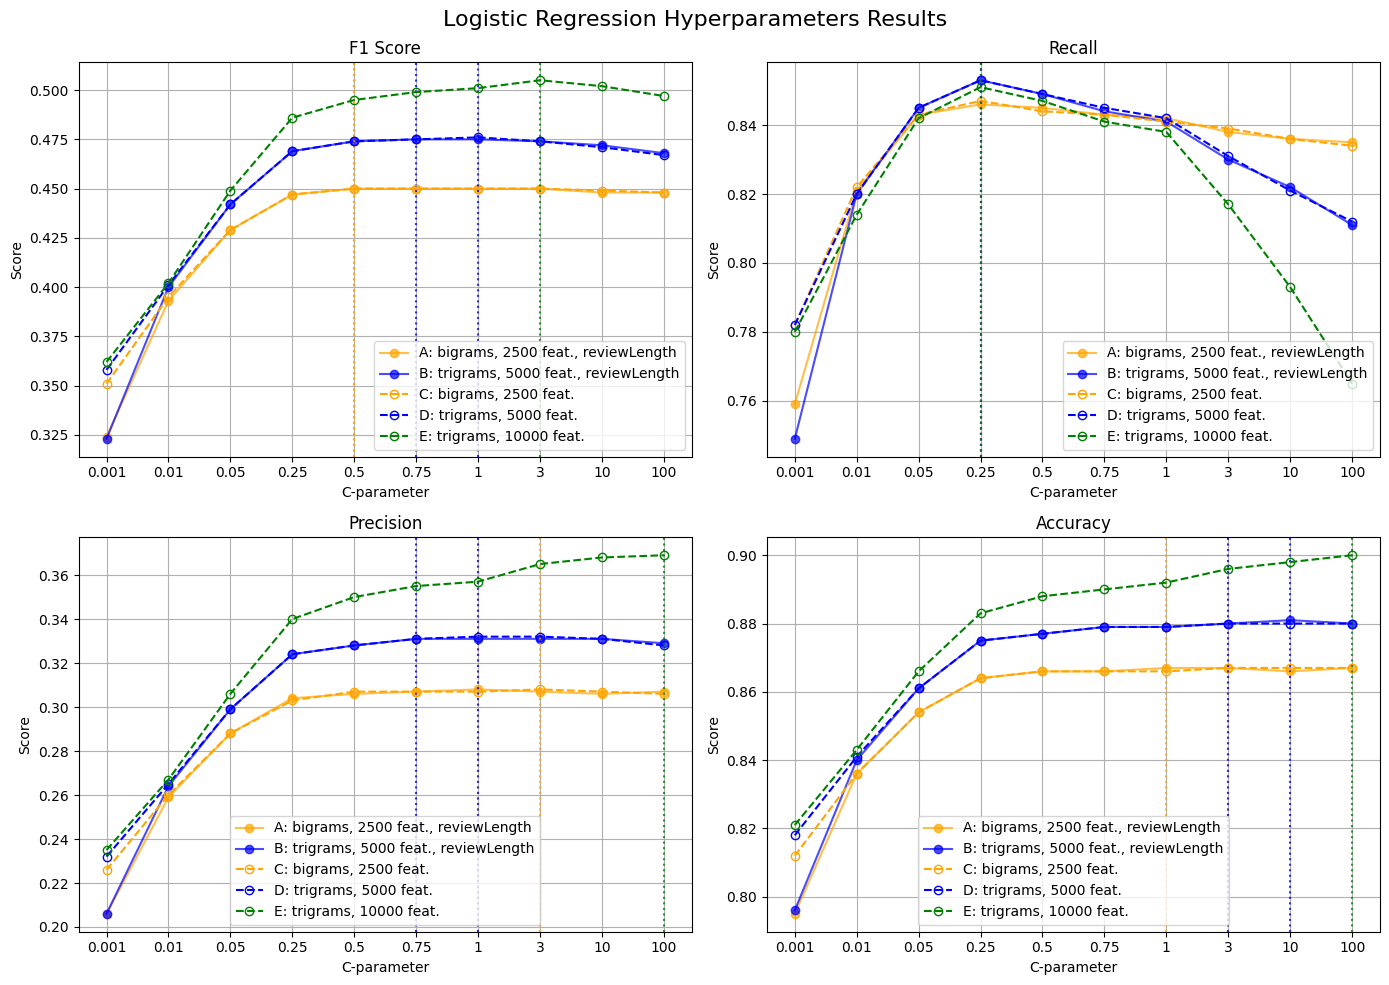

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# List of metrics and their titles
metrics = ['F1', 'Recall', 'Precision', 'Accuracy']
titles = ['F1 Score', 'Recall', 'Precision','Accuracy']

for i, metric in enumerate(metrics):
    row = i // 2
    col = i % 2
    ax = axes[row, col]

    # Plot metric for each model variant, with vertical for best C-parameter
    plot_with_best(ax, lr_A_df, metric, 'A: bigrams, 2500 feat., reviewLength', 'orange')
    plot_with_best(ax, lr_B_df, metric, 'B: trigrams, 5000 feat., reviewLength', 'blue')
    plot_with_best(ax, lr_C_df, metric, 'C: bigrams, 2500 feat.', 'orange', linestyle='--', markerface='none')
    plot_with_best(ax, lr_D_df, metric, 'D: trigrams, 5000 feat.', 'blue', linestyle='--', markerface='none')
    plot_with_best(ax, lr_E_df, metric, 'E: trigrams, 10000 feat.', 'green', linestyle='--', markerface='none')

    # Set axes, grid and legend
    ax.set_title(titles[i])
    ax.set_xlabel('C-parameter')
    ax.set_ylabel('Score')
    ax.set_xticks(list(range(len(c_params))))
    ax.set_xticklabels(c_params)
    ax.grid()
    ax.legend()

fig.suptitle("Logistic Regression Hyperparameters Results", fontsize=16)
plt.tight_layout()
plt.show()

## Comments and conclusions on hyperparameter tuning for Logistic Regression

Comments about the graphs above:
* Model pairs A and C (orange continuous and dashed lines respectively) and B and D (blue continuous and dashed lines) produce almost identical results. The only difference within these variants is whether they incorporate the length of the review as an additional feature (continuous lines) or not (dashed lines). Clearly, the **length of the review does not provide significant improvement** to the models, in fact it does the opposite for very low values of the C-parameter where the regularization is stronger.

* Model E (green dashed line) shows consistently better results almost across the board, except with "recall". This model is the most complex of the five, as its Bag of Words contains 10000 features (instead of 2500 or 5000 like the other variants). Because 'reviewLength' did not seem to add significant improvements for the other variations of the model and because I feared it would take a long time to run it, I decided not to include a version of this model with 'reviewLength'.

* Interestingly enough, **all model variants obtain best recall at C = 0.25**, where regularization is fairly strong but not excessive, with some coefficients more heavily penalized, allowing for better generalization when features are noisy or high-dimensional (like I expect to be the case here: "A customer that gives 3 stars, is that really "positive sentiment"?).

* It is worth noticing also that **accuracy continues to increase for higher values of c** then those discussed, when weights become less constrained by the model, which is further evidence of the large bias in the dataset: if we always predicted negSentiment = 0, we would be correct 93.5% of the time.

* Since the dataset is so unbalanced, it is difficult to train the model well for detecting the minority class: negative sentiment. If this project were to be used to detect unhappy customers quickly, at the risk of also including customers that are happy with the product, "recall" would be the most relevant metric, but since it is important to find a good compromise between detecting negative sentiment (achieved with a high recall) while not generating too many false hits (achieved with a high precision), I will mostly take into account the F1 score.

* The best F1 score is achieved by model E for C = 3, but this also coincides with a drop in recall score. Thus I will choose **c = 1**, which still yields a very good F1 score and gives much better recall.


---


### Selected Logistic Regression model for training on full dataset:

**Logistic Regression on X_test_cvmax (10000 features, 1-, 2-, and 3-grams, and no 'reviewText'), with C = 1.**

This model gave the following results during cross-validation:
* F1        = 0.501
* recall    = 0.838
* precision = 0.357
* accuracy  = 0.892


In [30]:
#######################################
###     RandomForestClassifier      ###
### (with seed for reproducibility) ###
#######################################

# Initialise list of dictionaries to store results
rf_results = []

# Initialise best parameter variables
best_f1 = 0
best_params = None

for n in [50, 100, 200]:
    for d in [5, 10, 20]:
        rf_model = RandomForestClassifier(
            n_estimators=n,
            max_depth=d,
            class_weight='balanced',
            n_jobs=-1,
            random_state=42,
            verbose=1
        )
        scores = cross_validate(rf_model, X_train_final_cv12, y_train, cv=5, scoring=scoring)

        mean_f1 = np.mean(scores['test_f1'])
        mean_precision = np.mean(scores['test_precision'])
        mean_recall = np.mean(scores['test_recall'])

        rf_results.append({
            'n_estimators': n,
            'max_depth': d,
            'mean_f1': mean_f1,
            'mean_precision': mean_precision,
            'mean_recall': mean_recall
        })
        if mean_f1 > best_f1:
          best_f1 = mean_f1
          best_params = {'n_estimators': n, 'max_depth': d}

# Convert to DataFrame for easy display
rf_df = pd.DataFrame(rf_results)
rf_df


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.4s
[Parall

,n_estimators,max_depth,mean_f1,mean_precision,mean_recall
0,50,5,0.327309,0.217827,0.658485
1,50,10,0.357605,0.241139,0.691798
2,50,20,0.415380,0.305605,0.648873
3,100,5,0.327093,0.215207,0.681603
4,100,10,0.362747,0.245129,0.697642
5,100,20,0.423992,0.312424,0.659718
6,200,5,0.321954,0.209318,0.697383
7,200,10,0.354916,0.235978,0.715760
8,200,20,0.421806,0.308783,0.665497


In [31]:
# Sort RandomForest results (best at the top)
rf_df.sort_values('mean_f1', ascending=False)

,n_estimators,max_depth,mean_f1,mean_precision,mean_recall
5,100,20,0.423992,0.312424,0.659718
8,200,20,0.421806,0.308783,0.665497
2,50,20,0.415380,0.305605,0.648873
4,100,10,0.362747,0.245129,0.697642
1,50,10,0.357605,0.241139,0.691798
7,200,10,0.354916,0.235978,0.715760
0,50,5,0.327309,0.217827,0.658485
3,100,5,0.327093,0.215207,0.681603
6,200,5,0.321954,0.209318,0.697383


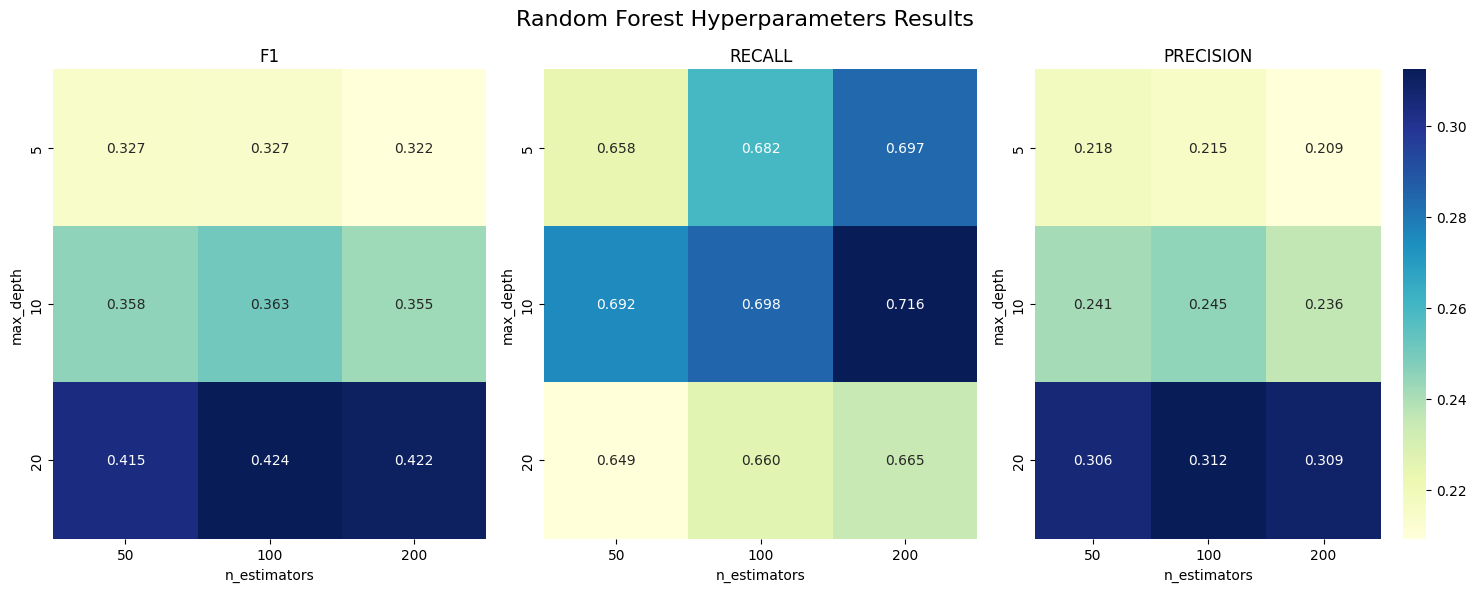

In [32]:
# Seaborn heat map to display Random Forest Hyperparameter Tuning results

metrics = ['mean_f1','mean_recall','mean_precision']
fig, axes = plt.subplots(1, 3, figsize=(15,6))

for ax, metric in zip(axes, metrics):
    pivot = rf_df.pivot(index='max_depth', columns='n_estimators', values=metric).sort_index(ascending=True)
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="YlGnBu", cbar=ax is axes[-1], ax=ax)
    ax.set_title(metric.replace('mean_','').upper())
    ax.set_xlabel('n_estimators')
    ax.set_ylabel('max_depth')

fig.suptitle("Random Forest Hyperparameters Results", fontsize=16)
plt.tight_layout()
plt.show()

## Comments and conclusions about Random Forest parameter tuning

From the heat map above, it is easy to see that the **best F1 score and also best precision are achieved for 100 trees with a depth of 20**. Recall seems to do better with more trees (200) and less depth (10).

If the goal of this analysis were to identify potential unhappy customers at the risk of overdoing it, I would priorize the recall results. However, here I will choose the F1 score, as it is a good compromise between recall and precision.

It would be worth exploring the same model with more vectorization features and also more estimators and depth values if time weren't of the essence. However, tree-models are quite time-consuming to train so I will leave it at this.


---


### Selected RandomForestClassifier model for training on full dataset:

**RandomForestClassifier on X_test_final_cv12 (2500 features, 1- and 2-grams, and 'reviewText'), with max_depth=20 and n_estimators=100.**

This model gave the following results during cross-validation:

* F1        = 0.424
* precision = 0.312
* recall    = 0.660

## 3. Training of the two selected models over the entire training data

During cross-validation, the **Logistic Regression models** consistently yielded higher F1 scores for any C > 0.1 than the best Random Forest model. As such, this is the model I will select as the **final model**.

Best result achieved by each model:

* Logistic Regression with C = 1, using n-gram range (1,3) and max_features = 10000 for TF-IDF:

   **F1 = 0.501**, precision = 0.357, recall = 0.838

* Random Forest Classifier with n_estimators = 100 trees and depth = 20, using n-gram range (1,2) and max_features = 2500 for TF-IDF as well as reviewLength as an additional feature:

   **F1 = 0.424**, precision = 0.312, recall = 0.660

I will be fitting both of these models over the entire training dataset, and commenting/contrasting some results afterwards.

In [33]:
####################################################################
### 1. LOGISTIC REGRESSION WITH 1,2,3-GRAMS AND 10000 PARAMETERS ###
####################################################################

# Logistic Regression classifier model
best_C = 1
lr_clf = LogisticRegression(
    C=best_C,
    class_weight='balanced',
    max_iter=1000,
    solver='lbfgs',
    n_jobs=-1
)

# Fit on the TF-IDF matrix
lr_clf.fit(X_train_cvmax, y_train)


LogisticRegression(C=1, class_weight='balanced', max_iter=1000, n_jobs=-1)

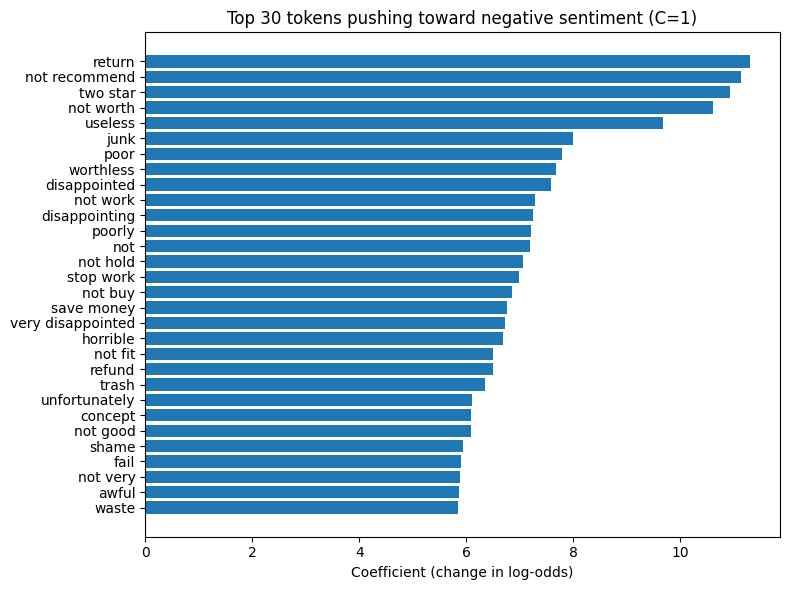

In [34]:
# Inspect coefficients and plot top tokens
feature_names = np.array(cvmax.get_feature_names_out())
coefs = lr_clf.coef_.ravel()

top_k = 30
top_idx = np.argsort(coefs)[-top_k:]
top_features = feature_names[top_idx]
top_weights = coefs[top_idx]

order = np.argsort(top_weights)
labels = top_features[order]
values = top_weights[order]

plt.figure(figsize=(8, max(4, top_k*0.2)))
plt.barh(range(len(values)), values, color='C0')
plt.yticks(range(len(values)), labels)
plt.xlabel('Coefficient (change in log-odds)')
plt.title(f'Top {top_k} tokens pushing toward negative sentiment (C={best_C})')
plt.tight_layout()
plt.show()

In [47]:
!pwd

/content/drive/MyDrive/KeepCoding/NLP/Project


In [95]:
# Save Logistic Regression model to Google Drive
lr_clf_path = 'lr_clf.pkl'
joblib.dump(lr_clf, lr_clf_path)

['lr_clf.pkl']

In [35]:
#####################################################################################
### 2. RANDOM FOREST CLASSIFIER WITH 1,2-GRAMS, 2500 PARAMETERS AND REVIEW LENGTH ###
#####################################################################################

best_params = {'n_estimators': 100, 'max_depth': 20}
best_f1 = 0.423992

print("Best model:", best_params, "with F1:", best_f1)

rf_clf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

rf_clf.fit(X_train_final_cv12, y_train)

Best model: {'n_estimators': 100, 'max_depth': 20} with F1: 0.423992


RandomForestClassifier(class_weight='balanced', max_depth=20, n_jobs=-1,
                       random_state=42)

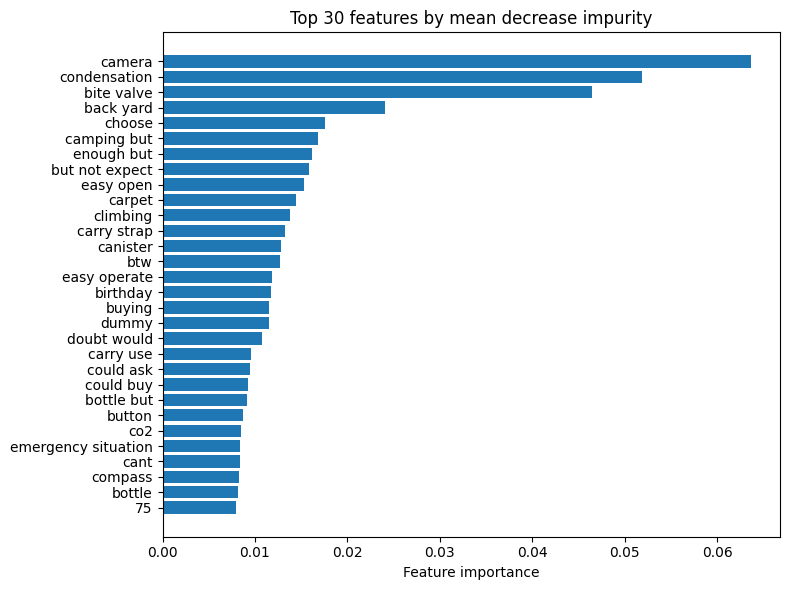

In [36]:
# Convert feature_names to a NumPy array
feature_names = np.array(feature_names)

# Display global feature importances
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[-30:]
plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), feature_names[indices])
plt.xlabel('Feature importance')
plt.title('Top 30 features by mean decrease impurity')
plt.tight_layout()
plt.show()

In [44]:
!pwd

/content/drive/MyDrive/KeepCoding/NLP/Project


In [94]:
# Save RandomForest model to Google Drive
rf_clf_path ='rf_clf.pkl'
joblib.dump(rf_clf, rf_clf_path)

['rf_clf.pkl']

## Commentary on the two models

**Logistic regression**

Looking at the 30 top tokens pushing towards negative sentiment, we see that the model heavily relies on obvious polarity words, such as *return, not recommend, 2 star, not worth, useless, junk, poor, worthless, disappointed, not worth, disappointing, poorly,...*

Many of the bigrams that appear are indeed made up of "not" + ADJ or "not" + VERB, and we also have 2 + "star". I also mentioned, when I originally explored the data, that it might be worth tagging combinations of "not" + word or of number + "star". But TF-IDF already captured these combinations and the model used them.

**Random Forest**

In contrast, the tree-based model seems to rely more on contextual and situational terms, rather than explicit sentiment vocabulary. The model is learning that negative sentiment often appears in specific usage contexts, indicating that negative sentiment is often expressed through descriptions of product performance in different situations rather than explicit opinion words.

For instance, it is utilizing usage terms (*carry strap, easy open, easy operate, climbing, camera*), types of situations (*camping, emergency situation, carpet, backyard*), interaction phrases (*btw, could ask, could buy*) and expectation-related and contrastive phrasing  (*but not expect, enough but,bottle but,camping but, doubt would*).  


# 4. Testing the models



I explained above that the model chosen is Logistic Regression Model. However, out of curiosity, I will begin by running the Random Forest model, make a quick comment about it, and then I will move onto  the final model and its evaluation and conclusions.

In [37]:
###########################
### Random Forest Model ###
###########################

# Predict
y_pred_rf = rf_clf.predict(X_test_final_cv12)

# Basic metrics
precision_rf = precision_score(y_test, y_pred_rf, pos_label=1)
recall_rf = recall_score(y_test, y_pred_rf, pos_label=1)
f1_rf = f1_score(y_test, y_pred_rf, pos_label=1)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print("RF — precision (pos):", precision_rf)
print("RF — recall (pos):", recall_rf)
print("RF — F1 (pos):", f1_rf)
print("RF — accuracy:", accuracy_rf)

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("RF — confusion matrix:\n", cm_rf)

# Full report
print("\nRF classification report:\n", classification_report(y_test, y_pred_rf, digits=4))

RF — precision (pos): 0.310302734375
RF — recall (pos): 0.6602597402597402
RF — F1 (pos): 0.4221890051486464
RF — accuracy: 0.8826010663427144
RF — confusion matrix:
 [[49768  5650]
 [ 1308  2542]]

RF classification report:
               precision    recall  f1-score   support

           0     0.9744    0.8980    0.9347     55418
           1     0.3103    0.6603    0.4222      3850

    accuracy                         0.8826     59268
   macro avg     0.6423    0.7792    0.6784     59268
weighted avg     0.9313    0.8826    0.9014     59268



I was expecting the model to do worse when running on new data, since it seemed that it may have been giving too much importance to the specific language of the training dataset, rather than language associated with sentiment.

However, I see that for the negative sentiment class (class 1), the results are very similar to the training results: **F1 = 0.424**, precision = 0.312, recall = 0.660

It turns out that the contextual usage patterns and contrastive phrasing used in descriptions of product performance can also be good indicators of sentiment.

In [38]:
#################################
### Logistic Regression Model ###
#################################

# Predict
y_pred_lr = lr_clf.predict(X_test_cvmax)

# Basic metrics (binary; adjust average for multiclass)
precision_lr = precision_score(y_test, y_pred_lr, pos_label=1)   # or pos_label='positive' as appropriate
recall_lr = recall_score(y_test, y_pred_lr, pos_label=1)
f1_lr = f1_score(y_test, y_pred_lr, pos_label=1)
accuracy_lr = accuracy_score(y_test, y_pred_lr)

print("LR — precision (pos):", precision_lr)
print("LR — recall (pos):", recall_lr)
print("LR — F1 (pos):", f1_lr)
print("LR — accuracy:", accuracy_lr)

# Confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
print("LR — confusion matrix:\n", cm_lr)

# Full report (includes per-class precision/recall/F1 and macro/micro averages)
print("\nLR classification report:\n", classification_report(y_test, y_pred_lr, digits=4))

LR — precision (pos): 0.35136010362694303
LR — recall (pos): 0.8454545454545455
LR — F1 (pos): 0.49641604392252553
LR — accuracy: 0.8885739353445367
LR — confusion matrix:
 [[49409  6009]
 [  595  3255]]

LR classification report:
               precision    recall  f1-score   support

           0     0.9881    0.8916    0.9374     55418
           1     0.3514    0.8455    0.4964      3850

    accuracy                         0.8886     59268
   macro avg     0.6697    0.8685    0.7169     59268
weighted avg     0.9467    0.8886    0.9087     59268



In [39]:
import pickle
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             accuracy_score, confusion_matrix, classification_report)
# Save results to a pickle file

# Predict
y_pred_lr = lr_clf.predict(X_test_cvmax)
y_pred_rf = rf_clf.predict(X_test_final_cv12)

# Compute metrics
results = {
    "lr": {
        "y_pred": y_pred_lr,
        "precision_pos": precision_score(y_test, y_pred_lr, pos_label=1),
        "recall_pos": recall_score(y_test, y_pred_lr, pos_label=1),
        "f1_pos": f1_score(y_test, y_pred_lr, pos_label=1),
        "accuracy": accuracy_score(y_test, y_pred_lr),
        "confusion_matrix": confusion_matrix(y_test, y_pred_lr),
        "classification_report": classification_report(y_test, y_pred_lr, digits=4)
    },
    "rf": {
        "y_pred": y_pred_rf,
        "precision_pos": precision_score(y_test, y_pred_rf, pos_label=1),
        "recall_pos": recall_score(y_test, y_pred_rf, pos_label=1),
        "f1_pos": f1_score(y_test, y_pred_rf, pos_label=1),
        "accuracy": accuracy_score(y_test, y_pred_rf),
        "confusion_matrix": confusion_matrix(y_test, y_pred_rf),
        "classification_report": classification_report(y_test, y_pred_rf, digits=4)
    },
    "y_test": y_test
}
# Save model results to file
with open("model_eval_results.pkl", "wb") as f:
    pickle.dump(results, f)

In [25]:
# To load model evaluation results from file
with open("model_eval_results.pkl", "rb") as f:
    results = pickle.load(f)

In [26]:
results

{'lr': {'y_pred': array([1, 1, 0, ..., 0, 0, 0]),
  'precision_pos': 0.35136010362694303,
  'recall_pos': 0.8454545454545455,
  'f1_pos': 0.49641604392252553,
  'accuracy': 0.8885739353445367,
  'confusion_matrix': array([[49409,  6009],
         [  595,  3255]]),
  'classification_report': '              precision    recall  f1-score   support\n\n           0     0.9881    0.8916    0.9374     55418\n           1     0.3514    0.8455    0.4964      3850\n\n    accuracy                         0.8886     59268\n   macro avg     0.6697    0.8685    0.7169     59268\nweighted avg     0.9467    0.8886    0.9087     59268\n'},
 'rf': {'y_pred': array([1, 0, 0, ..., 0, 0, 0]),
  'precision_pos': 0.310302734375,
  'recall_pos': 0.6602597402597402,
  'f1_pos': 0.4221890051486464,
  'accuracy': 0.8826010663427144,
  'confusion_matrix': array([[49768,  5650],
         [ 1308,  2542]]),
  'classification_report': '              precision    recall  f1-score   support\n\n           0     0.9744  

# Part 4: Evaluation and conclusion

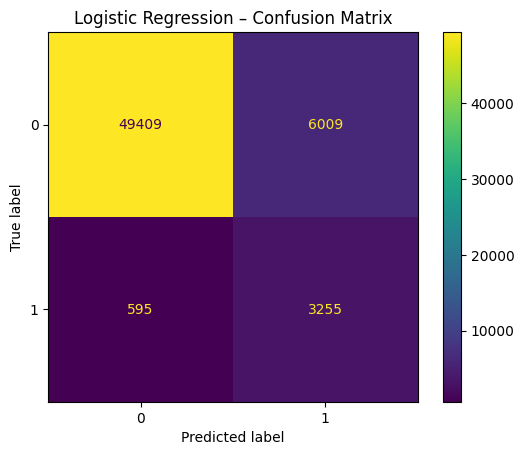

In [29]:
# Confusion matrix for Logistic Regression
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr)
plt.title("Logistic Regression – Confusion Matrix")
plt.show()

The confusion matrix shows:

* top left: True Negatives (TN) -> The model correctly predicted 49409 cases of positive sentiment. This is the highest count, in large part because there were so many cases of this class (55418 vs only 3850 for the Positive class).

* top right: False Positives (FP) -> the model incorrectly predicted negative sentiment on 6009 occasions. This high value of FP is responsible for the low precision achieved by the model.

* bottom left: False Negatives (FN) -> the model incorrectly predicted positive sentiment on only 595 occasions.

* bottom right: True Positives (TP) -> the model correctly predicted negative sentiment on 3255 occasions (out of the total 3850 cases).

**Conclusions on the confusion matrix**

Even though the model had a low amount of Positive class (negative sentiment) reviews, it was still able to recall many of the cases of negative sentiment. However, this came at the expense of also predicting negative sentiment for many of the reviews classified as positive sentiment.

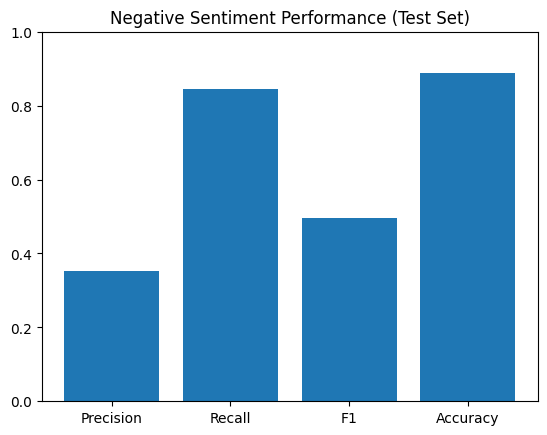

In [42]:
metrics = ['Precision', 'Recall', 'F1', 'Accuracy']
values = [0.3514, 0.8455, 0.4964, 0.8886]

plt.bar(metrics, values)
plt.title("Negative Sentiment Performance (Test Set)")
plt.ylim(0,1)
plt.show()

Thes bar graph illustrates that, while recall for the negative sentiment is high (almost comparable to accuracy), precision is relatively low. This reflects the trade-off that I chose to prioritize identifying dissatisfied customers.

In [33]:
# Calculation of probabilities for class with label 1 (negative sentiment)
y_prob_lr = lr_clf.predict_proba(X_test_cvmax)[:, 1]

In [34]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

In [35]:
# Compute precision-recall values
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_lr)
ap_score = average_precision_score(y_test, y_prob_lr)

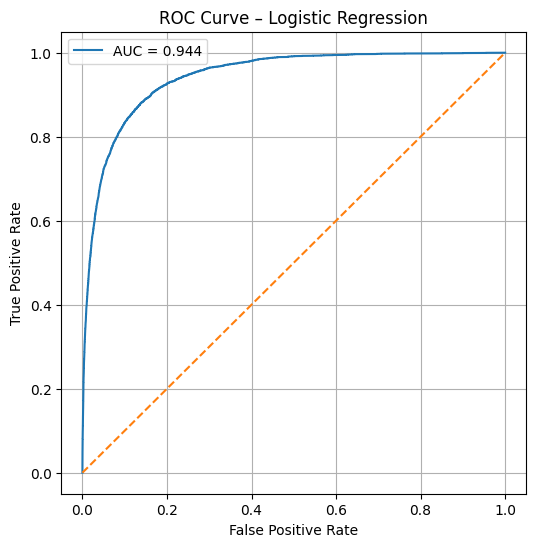

In [32]:
# Plot ROC curve
# (Not a good performance evaluator for unbalanced datasets)
fpr, tpr, thresholds = roc_curve(y_test, y_prob_lr)
auc_score = roc_auc_score(y_test, y_prob_lr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression")
plt.legend()
plt.grid()
plt.show()

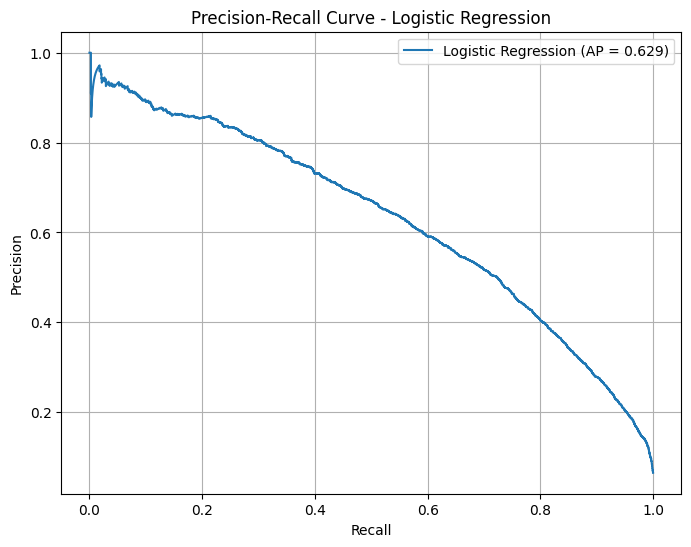

In [39]:
# Plot recall-precision curve
# (better performance tool for unbalanced datasets)

plt.figure(figsize=(8,6))

plt.plot(recall, precision, label=f'Logistic Regression (AP = {ap_score:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Logistic Regression')
plt.legend()
plt.grid()

plt.show()


## Comment on the ROC and Precision-Recall curves

The ROC (Receiver Operating Characteristics) curve is used to check how well a binary classification model works. It displays the relationship between true positive rate and false positive rate, helping to understand how well the model separates the positive cases (here, negative sentiment) from the negative cases (here, positive sentiment). The AUC (Area Under the Curve) in this case is high, suggesting that the model has a strong ability to distinguish between positive and negative sentiment in the reviews.

However, in the presence of strong class imbalance, the ROC curve can give an overly optimistic view of performance.  Unlike the ROC curve, the PR (Precision-Recall) curve focuses only on how well the model handles the positive class, in this case the minority class (negative sentiment). The PR curve shows the trade-off between Precision and Recall across different decision thresholds. An AP (Average Precision) score of 0.629 indicates that, while the model is able to predict a high proportion of negative reviews (high recall), this comes at the cost of lower precision.



# Final conclusion

The goal of this project was to detect negative sentiment in customer reviews, which are a minority class (6.5%) in a highly imbalanced dataset. Detecting dissatisfied customers is critical for business applications, as early identification allows companies to address issues promptly.

**Preprocessing and Feature Engineering**

In preprocessing, the reviews were tokenized, lemmatized, turned to lowercase, and stopwords were removed. Then TF-IDF vectorization was applied with n-grams in range (1,2) and even (1,3) for Logistic Regression, and a maximum vocabulary size to reduce dimensionality. This approach helped to capture key sentiment patterns, including negations and numeric ratings, without needing to tag manually.

The additional numeric feature 'reviewLength' was included because longer reviews often correlated with negative sentiment, as seen in boxplots during data exploration. However, its contribution was limited. I also considered including Chi-squared feature selection to reduce dimensionality, particularly for tree-based models.

**Model Selection and Hyperparameter**

Two dfferent models were evaluated with different hyperparameters using 5-fold cross-validation, and focusing on the F1 score of the negative class:

* Logistic Regression: easy to interpret, fast and effective in high-dimensional sparse text data. The final configuration used C = 1, 1-3 grams, and max_features = 10000.

* Random Forest: non linear, tree-based model able to capture contextual interactions. The final tuning was set at 100 trees, depth = 20, and 1-2 grams with max_features = 2500.

I addressed the heavy class imbalance by:
* setting class_weight = 'balanced
* including 2-grams and 3-grams to help capture negating and contrasting language
* prioritizing F1 score (and also recall when in doubt) for the negative sentiment class during tuning.

**Results and evaluation**

* Logistic Regression test results (negative sentiment class, 1):

  Precision = 0.351, Recall = 0.845, F1 = 0.496

* Random Forest test results (negative sentiment class, 1):

  Precision = 0.310, Recall = 0.660, F1 = 0.422


Focusing on the chosen model, Logistic Regression, the full classification report yielded these results:

In [41]:
print("\nLR classification report:\n", classification_report(y_test, y_pred_lr, digits=4))


LR classification report:
               precision    recall  f1-score   support

           0     0.9881    0.8916    0.9374     55418
           1     0.3514    0.8455    0.4964      3850

    accuracy                         0.8886     59268
   macro avg     0.6697    0.8685    0.7169     59268
weighted avg     0.9467    0.8886    0.9087     59268



Because the dataset is highly imbalanced, **micro precision (0.886)** and other micro metrics are dominated by the majority class and can give an overly optimistic view of performance. In contrast, **macro precision (0.6697)** better reflects the model's difficulties when predicting the minority class.  

The analysis of the confusion matrix for Logistic Regression showed that while some positive reviews were misclassified as negative (6009 false positives), the model successfully captured the majority of negative reviews (3255 true positives out of 3850). This aligns with the goal of high recall for detecting unhappy customers.

The high value of ROC AUC indicated a strong overall class separation. However, the Precision-Recall curve (AP = 0.629) provided a more realistic view in this imbalanced setting, confirming the model's ability to capture negative reviews, but at the expense of precision.

**Model interpretability**

Logistic Regression relies heavily on explicit polarity words and n-gram combinations (*not recommend, 2 star, very disappointed*), showing that simple linear relationships are sufficient for this dataset.

Random Forest captures contextual and situational phrases (*carry strap, camping but, easy open*), showing that negative sentiment is often expressed through context rather than necessarily opinion words. However, these patterns did not improve predictive performance compared to Logistic Regression.

**Reflections and Potential Improvement**

The model could be further improved by exploring chi-squared feature selection, alternative TF-IDF configurations, additional hyperparameter tuning, or re-evaluating the labeling of borderline reviews (for instance, whether 3 stars should always be positive).

Despite limitations, the final Logistic Regression model demonstrates a strong ability to detect negative sentiment (recall = 0.845), validating the preprocessing choices, feature design, and purposeful focus on minority-class detection.

**Conclusion**

I selected Logistic Regression as the final model due to its high recall, competitive F1 score, interpretability, ability to work with more complex vectorization, and efficiency during training. Random Forest provided valuable insight into contextual patterns but did not outperform the linear model. TF-IDF with n-grams alone proved sufficient to capture the main sentiment signals, justifying the simplified preprocessing pipeline.